In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from sklearn.metrics import confusion_matrix, roc_curve### metrics
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


Data Preparation


**Data Loading**





In [4]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

In [5]:
print(len(dataset[0]))

27558


In [6]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [16]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [7]:
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1

In [8]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )


In [9]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2755
2757


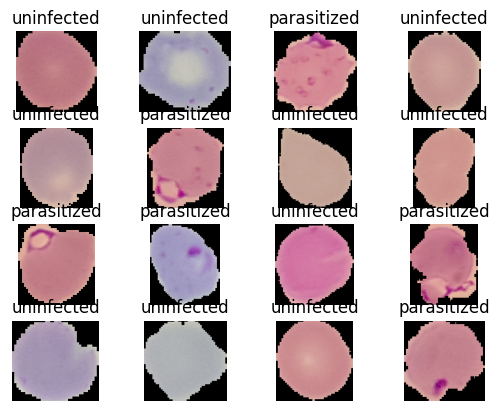

In [10]:
for i ,(image , label ) in enumerate(train_dataset.take(16)):
  ax=plt.subplot(4,4,i+1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')


**Data Preprocessing**


In [11]:
IM_SIZE = 224



def resize_rescale(image , label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0, label


train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)



In [12]:
test_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
BATCH_SIZE = 32


train_dataset = (train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))


**Sequential API**

In [14]:
# IM_SIZE = CONFIGURATION['IM_SIZE']
# DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
# REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
# N_FILTERS = CONFIGURATION['N_FILTERS']
# KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
# POOL_SIZE = CONFIGURATION['POOL_SIZE']
# N_STRIDES = CONFIGURATION['N_STRIDES']


lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),


    Conv2D(filters =16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),

    Dense( 100, activation = "relu"),
    BatchNormalization(),


    Dense( 10, activation = "relu", ),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

In [15]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics='accuracy')

In [18]:

history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 41s 50ms/step - loss: 0.3963 - accuracy: 0.8204 - val_loss: 1.3755 - val_accuracy: 0.5009
Epoch 2/20
689/689 [==============================] - 34s 49ms/step - loss: 0.2133 - accuracy: 0.9243 - val_loss: 0.2309 - val_accuracy: 0.9263
Epoch 3/20
689/689 [==============================] - 33s 49ms/step - loss: 0.1814 - accuracy: 0.9382 - val_loss: 0.2807 - val_accuracy: 0.8690
Epoch 4/20
689/689 [==============================] - 34s 49ms/step - loss: 0.1680 - accuracy: 0.9451 - val_loss: 0.2492 - val_accuracy: 0.9394
Epoch 5/20
689/689 [==============================] - 33s 48ms/step - loss: 0.1567 - accuracy: 0.9489 - val_loss: 0.3687 - val_accuracy: 0.8305
Epoch 6/20
689/689 [==============================] - 34s 49ms/step - loss: 0.1436 - accuracy: 0.9524 - val_loss: 0.2551 - val_accuracy: 0.9194
Epoch 7/20
689/689 [==============================] - 34s 49ms/step - loss: 0.1497 - accuracy: 0.9498 - val_loss: 0.1610 - val_accuracy:

**Visualizations**

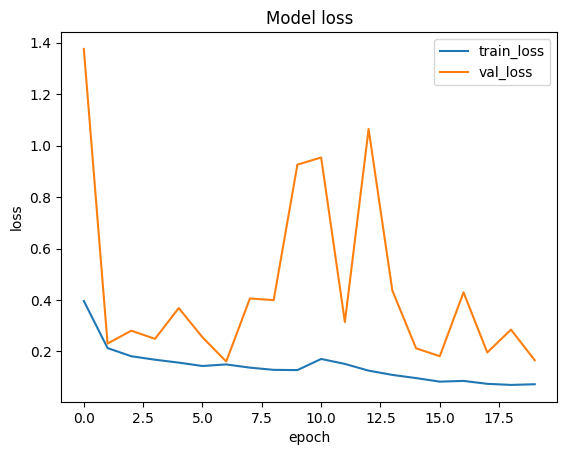

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

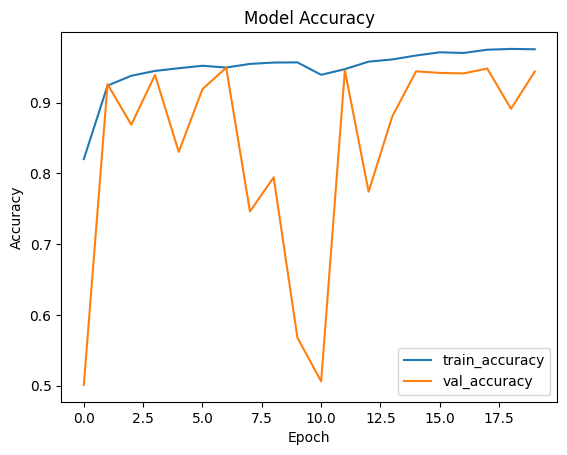

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

**Model Evaluation and Testing**

In [21]:
test_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [22]:
test_dataset = test_dataset.batch(1)



In [23]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 7s 2ms/step - loss: 0.1969 - accuracy: 0.9420


[0.1969439536333084, 0.9419658780097961]

**saving the model**

In [28]:
lenet_model.save('my_model.keras')

In [26]:
import pickle

# Assuming 'history' is the history object returned by model.fit()
with open('saved_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
